In [ ]:

import os
import util
from util import FWHM
import model as m

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

import hls4ml

/home/diptarko/.local/lib/python3.8/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [2]:
phi_div  = 64
eta_div  = 64
pt_div   = 64
qual_div = 64

hidden_neurons = 16
k_reg          = kernel_regularizer=regularizers.l2(1e-4)
a_reg          = kernel_regularizer=regularizers.l2(1e-4)
ap_fixed       = [12, 3]
target_sparsity = 0.2

n_epochs     = 100
batch_size   = 1024

lr = 1e-4
device = 0

train   = True
pruning = False

ckpt_file      = "checkpoints/run3_uGMT_nn_recal_checkpoint.h5"

In [4]:
DATAPATH  = "/home/rardino/data/run3/"
MODELPATH = "./models/run3/"

if not os.path.exists(MODELPATH): os.makedirs(MODELPATH)

/home/diptarko/Refactory/util.py:96: UserWarning: The limits are expected to be the exact float values and not the converted integer counter parts
  warnings.warn("The limits are expected to be the exact float values and not the converted integer counter parts")


train_len =  619108
Train df shape: (619108, 34)
Test  df shape: (32585, 34)
X train shape: (619108, 5)
Y train shape: (619108, 3)
X test  shape: (32585, 5)
Y test  shape: (32585, 3)


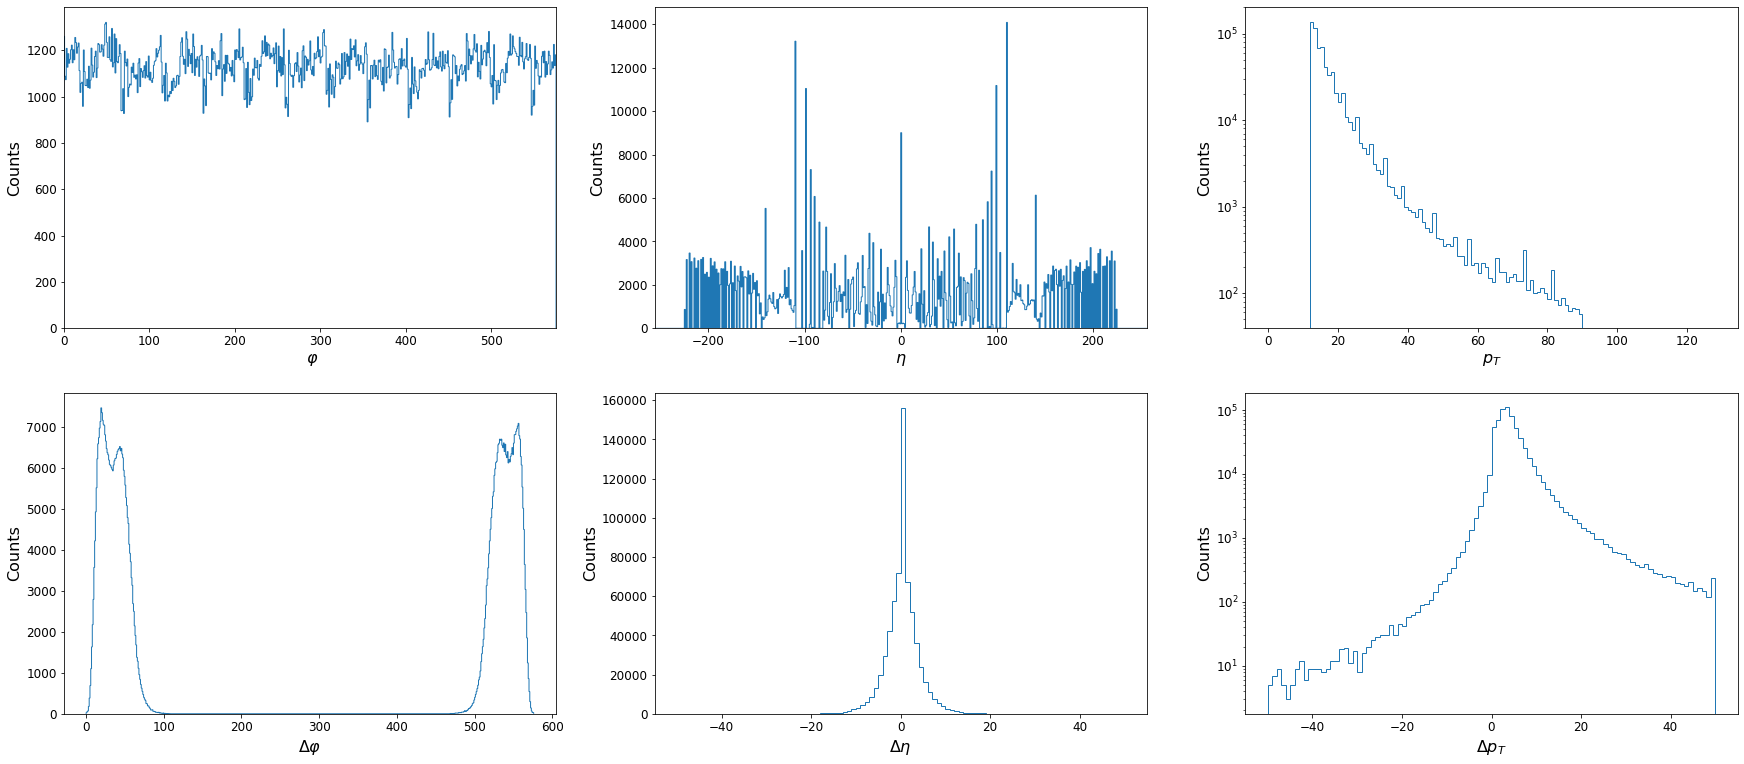

In [5]:
df_base =util.load_data([
    os.path.join(DATAPATH,"run3golden_mm_singles.csv")
                 ])
df_base = util.apply_cut(df_base, 5.5, 45)
train_data, test_data, df_train, df_test = util.preprocess_data(df_base)
x_train, y_train = train_data
x_test, y_test = test_data
util.plot_data(df_base)

In [6]:
model = m.make_model(hidden_neurons=hidden_neurons,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed)

if pruning:
    pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(target_sparsity, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

opt          = Adam(learning_rate=lr)
losses       = ['logcosh', 'logcosh', 'logcosh']
loss_weights = [1, 1, 1]

2023-10-06 17:41:48.259625: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 17:41:53.239610: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10393 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2023-10-06 17:41:53.304233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10407 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hd1 (QDense)                 (None, 16)                96        
_________________________________________________________________
bn1 (QBatchNormalization)    (None, 16)                64        
_________________________________________________________________
act1 (QActivation)           (None, 16)                0         
_________________________________________________________________
hd2 (QDense)                 (None, 16)                272       
_________________________________________________________________
bn2 (QBatchNormalization)    (None, 16)                64        
_________________________________________________________________
act2 (QActivation)           (None, 16)                0         
_________________________________________________________________
hd3 (QDense)                 (None, 16)                2

In [ ]:
if train:
    early_stopping = EarlyStopping(
        monitor  = 'val_loss',
        patience = 20
    )
    reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                               factor=0.5,
                                                               patience=5,
                                                               verbose=1,
                                                               mode="auto",
                                                               min_delta=0.0001,
                                                               cooldown=0,
                                                               min_lr=0)

    callbacks = [early_stopping,reduce_lr_on_plateu,
                 FWHM(x_test,y_test,df_test,use_wandb=False,verbose=True),
                 pruning_callbacks.UpdatePruningStep()
                 ]

    with tf.device(f'/device:GPU:{device}'):    
            model.compile(
                loss         = losses,
                loss_weights = loss_weights,
                optimizer    = opt,

            )

            model.fit(
                x_train, y_train,
                callbacks=callbacks,
                batch_size=batch_size,
                epochs=n_epochs,
                validation_split=0.1,
                shuffle=True,
                verbose = 1
            )

2023-07-25 13:12:36.624174: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
545/545 [==============================] - 6s 7ms/step - loss: 0.1404 - val_loss: 0.0625
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT-EXT 0.06499999999999995
FWHM pt uGMT 0.49000000000000044
-------------------------------------
FWHM phi NN 0.49700000000000044
FWHM eta NN 0.2260000000000002
FWHM pt-NN 0.39700000000000046
-------------------------------------
-------------------------------------
Epoch 2/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0425 - val_loss: 0.0288
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT-EXT 0.06499999999999995
FWHM pt uGMT 0.49000000000000044
------------

545/545 [==============================] - 3s 5ms/step - loss: 0.0151 - val_loss: 0.0150
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT-EXT 0.06499999999999995
FWHM pt uGMT 0.49000000000000044
-------------------------------------
FWHM phi NN 0.18000000000000005
FWHM eta NN 0.07300000000000006
FWHM pt-NN 0.5530000000000005
-------------------------------------
-------------------------------------
Epoch 16/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0148 - val_loss: 0.0147
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT-EXT 0.06499999999999995
FWHM pt uGMT 0.49000000000000044
-----------------------

545/545 [==============================] - 3s 5ms/step - loss: 0.0125 - val_loss: 0.0125
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT-EXT 0.06499999999999995
FWHM pt uGMT 0.49000000000000044
-------------------------------------
FWHM phi NN 0.14900000000000013
FWHM eta NN 0.06700000000000006
FWHM pt-NN 0.4790000000000003
-------------------------------------
-------------------------------------
Epoch 30/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0124 - val_loss: 0.0126
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT-EXT 0.06499999999999995
FWHM pt uGMT 0.49000000000000044
-----------------------

545/545 [==============================] - 3s 5ms/step - loss: 0.0115 - val_loss: 0.0116
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT-EXT 0.06499999999999995
FWHM pt uGMT 0.49000000000000044
-------------------------------------
FWHM phi NN 0.15000000000000013
FWHM eta NN 0.06599999999999995
FWHM pt-NN 0.4400000000000003
-------------------------------------
-------------------------------------
Epoch 44/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0115 - val_loss: 0.0118
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT-EXT 0.06499999999999995
FWHM pt uGMT 0.49000000000000044
-----------------------

545/545 [==============================] - 3s 5ms/step - loss: 0.0110 - val_loss: 0.0112
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT-EXT 0.06499999999999995
FWHM pt uGMT 0.49000000000000044
-------------------------------------
FWHM phi NN 0.14000000000000024
FWHM eta NN 0.06700000000000017
FWHM pt-NN 0.4500000000000003
-------------------------------------
-------------------------------------
Epoch 58/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0110 - val_loss: 0.0113
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT-EXT 0.06499999999999995
FWHM pt uGMT 0.49000000000000044
-----------------------

545/545 [==============================] - 3s 5ms/step - loss: 0.0108 - val_loss: 0.0110

Epoch 00071: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT-EXT 0.06499999999999995
FWHM pt uGMT 0.49000000000000044
-------------------------------------
FWHM phi NN 0.14100000000000001
FWHM eta NN 0.06600000000000006
FWHM pt-NN 0.4420000000000005
-------------------------------------
-------------------------------------
Epoch 72/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0108 - val_loss: 0.0109
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT

545/545 [==============================] - 3s 5ms/step - loss: 0.0108 - val_loss: 0.0110
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT-EXT 0.06499999999999995
FWHM pt uGMT 0.49000000000000044
-------------------------------------
FWHM phi NN 0.14100000000000001
FWHM eta NN 0.06499999999999995
FWHM pt-NN 0.4680000000000005
-------------------------------------
-------------------------------------
Epoch 86/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0108 - val_loss: 0.0110

Epoch 00086: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2310000000000002
-------------------------------------
FWHM eta uGMT 0.08200000000000007
FWHM eta uGMT-

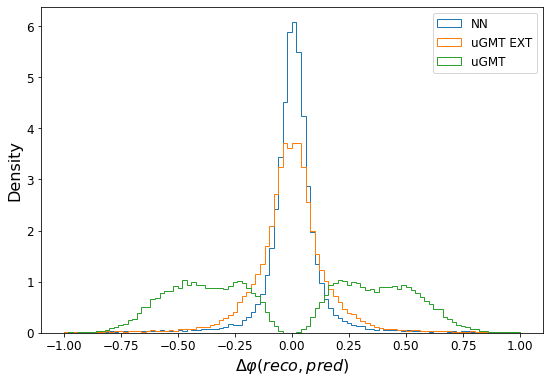

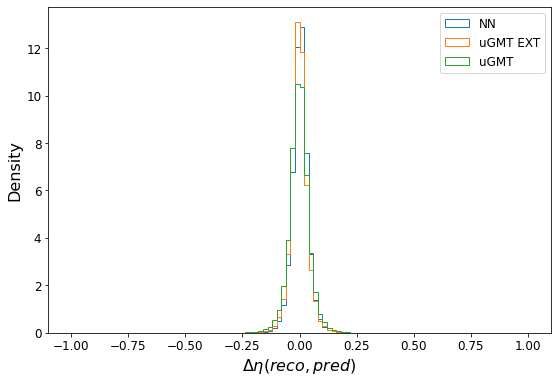

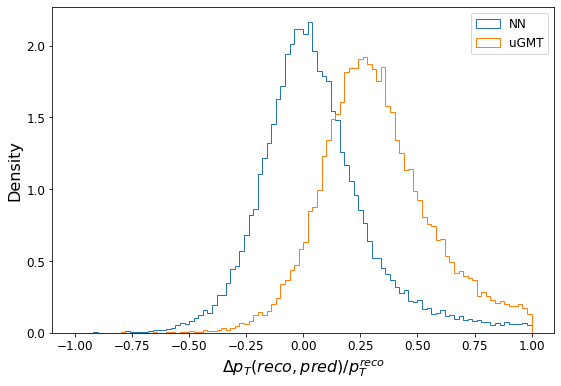

FWHM of delta_phi for the Neural Network Qkeras 0.14000000000000024
FWHM of delta_eta for the Neural Network Qkeras 0.06600000000000006
FWHM of delta_pt for the Neural Network Qkeras 0.4330000000000004


In [9]:
util.evaluate_keras(model = model,
                   x_test = x_test,
                   y_test = y_test,
                   df_train = df_train,
                   df_test = df_test,
                   phi_div = phi_div,
                   eta_div = eta_div,
                   pt_div = pt_div,
                   qual_div = qual_div,
                   batch_size = 2048)

In [8]:
model = strip_pruning(model)
config = hls4ml.utils.config_from_keras_model(model, granularity='model')
config["Model"]["Precision"] = "ap_fixed<18,6>"
config['Model']['ReuseFactor'] = 4
c_config = hls4ml.converters.create_config(project_name ='nn_test',
                                           output_dir="tmp/hls4ml_test",
                                           clock_period=4,
                                           part='xcvu37p-fsvh2892-2L-e',
                                           backend='Vivado')
c_config['HLSConfig'] = config
c_config['KerasModel'] = model
hls_model = hls4ml.converters.convert_from_config(c_config)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: hd1_input, layer type: InputLayer, input shapes: [[None, 5]], output shape: [None, 5]
Layer name: hd1, layer type: QDense, input shapes: [[None, 5]], output shape: [None, 16]
Layer name: bn1, layer type: QBatchNormalization, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: act1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: hd2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: bn2, layer type: QBatchNormalization, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: act2, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: hd3, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: bn3, layer type: QBatchNormalization, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: act3, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer

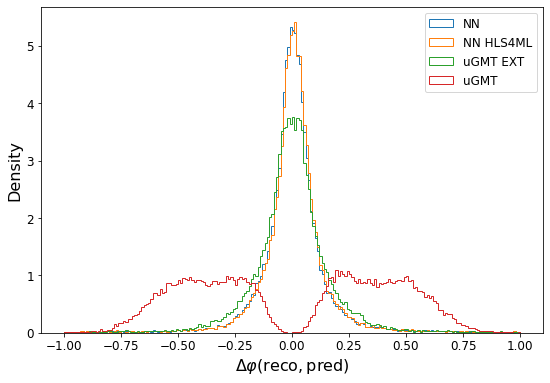

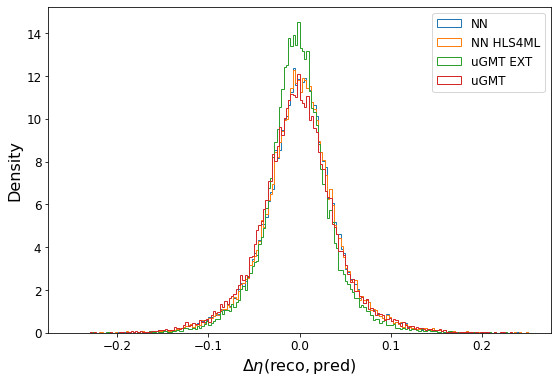

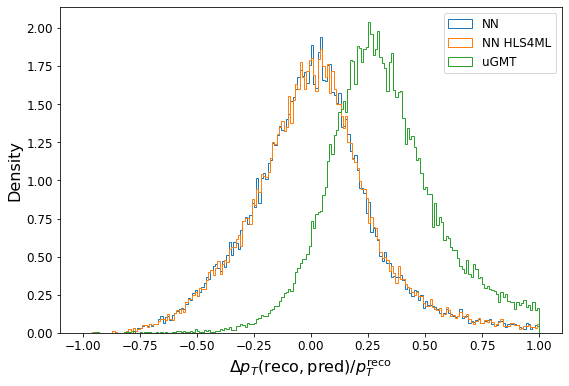

FWHM of delta_phi for the Neural Network Qkeras 0.16200000000000003
FWHM of delta_eta for the Neural Network Qkeras 0.07600000000000007
FWHM of delta_pt for the Neural Network Qkeras 0.5320000000000005

FWHM of delta_phi for the Neural Network HLS4ML 0.16300000000000003
FWHM of delta_eta for the Neural Network HLS4ML 0.07600000000000007
FWHM of delta_pt for the Neural Network HLS4ML 0.5350000000000006


In [14]:
util.evaluate_hls(hls_model = hls_model,
                  keras_model = model,
                   x_test = x_test,
                   y_test = y_test,
                   df_train = df_train,
                   df_test = df_test,
                   phi_div = phi_div,
                   eta_div = eta_div,
                   pt_div = pt_div,
                   qual_div = qual_div
                 )

In [9]:
os.environ["OMP_NUM_THREADS"] = "10"
os.environ['PATH'] = '/home/xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
os.environ['LD_LIBRARY_PATH'] = '/usr/lib64'

hls_logs = hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/home/xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'diptarko' on host 'pcgpu-c2f07-18-01.cern.ch' (Linux_x86_64 version 4.18.0-497.el8.x86_64) on Fri Oct 06 17:43:30 CEST 2023
INFO: [HLS 200-10] On os "CentOS Stream release 8"
INFO: [HLS 200-10] In directory '/home/diptarko/Refactory/tmp/hls4ml_test'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/diptarko/Refactory/tmp/hls4ml_test/nn_test_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/nn_test.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'nn_test_test.cpp' to the project
INFO: [HLS 200-10] Add

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, relu_config17>' (firmware/nnet_utils/nnet_activation.h:40:43).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>' (firmware/nnet_utils/nnet_batchnorm.h:37:47).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [XFORM 203-502] Unrol

INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:40) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:48) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:54) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:56) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18>'(firmware/nnet_utils/nnet_dense_latency.h:26:1) to 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18>.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/nn_test.cpp:97) by setting 'weights.V' to 'w18.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18>.0'(firmware/nnet_utils/nnet_dense_latency.h:26:1) to 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/nn_test.cpp:97) by setting 'biases[0].V' to 'b18.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latenc

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_test.cpp:91) by setting 'bias[4].V' to 'b16.V.4'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_test.cpp:91) by setting 'bias[5].V' to 'b16.V.5'.
IN

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/nn_test.cpp:87) by setting 'biases[6].V' to 'b14.V.6'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/nn_test.cpp:87) by setting 'biases[7].V' to 'b14.V.7'.
IN

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_test.cpp:79) by setting 'scale[10].V' to 's12.V.10'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_test.cpp:79) by setting 'scale[11].V' to 's12.V.11'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_test.cpp:79) by setting 'bias[11].V' to 'b12.V.11'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmwa

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_test.cpp:67) by setting 'scale[13].V' to 's8.V.13'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_test.cpp:67) by setting 'scale[14].V' to 's8.V.14'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normal

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/nn_test.cpp:63) by setting 'weights.V' to 'w6.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/nn_test.cpp:63) by setting 'biases[0].V' to 'b6.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_test.cpp:55) by setting 'bias[1].V' to 'b4.V.1'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_test.cpp:55) by setting 'bias[2].V' to 'b4.V.2'.
INFO: [XFORM 203-622] Instantiat

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:26:9) to 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0' by setting 'biases[4].V' to 'b2.V.4'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:26:9) to 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0' by setting 'biases[5].V' to 'b2.V.5'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:00:45 ; elapsed = 00:00:53 . Memory (MB): peak = 1080.344 ; gain = 658.125 ; free physical = 57430 ; free virtual = 276175
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'nn_test' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_ap_fixed_ap_fixed_config2_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed,ap_fixed,config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 4, Final II = 3, Depth = 3.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 53.3 seconds; current allocated memory: 310.953 MB.
INFO: [BIND 205-100] Starting micro-architecture

INFO: [HLS 200-111]  Elapsed time: 0.15 seconds; current allocated memory: 323.206 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.12 seconds; current allocated memory: 323.600 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_ap_fixed_ap_fixed_config10_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed,ap_fixed,config10>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 4, Final II = 3, Depth = 3.
INFO: [SCHED 204-11] Fini

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 6.64 seconds; current allocated memory: 349.176 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_ap_fixed_ap_fixed_config2_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_ap_fixed_ap_fixed_config2_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0'.
INFO: [HLS 200-111]  Elapsed time: 2.59 seconds; current allocated memory: 352.543 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'no

Vivado synthesis report not found.
Cosim report not found.
Timing report not found.


In [10]:
hls_logs

{'CSynthesisReport': {'TargetClockPeriod': '4.00',
  'EstimatedClockPeriod': '3.397',
  'BestLatency': '30',
  'WorstLatency': '30',
  'IntervalMin': '4',
  'IntervalMax': '4',
  'DSP': '238',
  'FF': '11647',
  'LUT': '33224',
  'BRAM_18K': '0',
  'URAM': '0',
  'AvailableBRAM_18K': '4032',
  'AvailableDSP': '9024',
  'AvailableFF': '2607360',
  'AvailableLUT': '1303680',
  'AvailableURAM': '960'}}